# Import

In [1]:
import configparser as cp
import pandas as pd
from ast import literal_eval

from scipy import stats

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
config = cp.RawConfigParser()
config.read(r'config.txt')

cat_file = config.get('liwc', 'category_file')
proc_file = config.get('main', 'proc_file')
proc_output = config.get('liwc', 'proc_output')

### Read relevant LIWC category names

In [3]:
# Read categories and their correlation coeficient to power
def read_cat_corr(cat_corr_file):
    df_cat_corr = pd.read_csv(cat_corr_file)
    cat_lst = df_cat_corr['cat'].tolist()
    corr_lst = df_cat_corr['corr'].tolist()
    return (cat_lst, corr_lst)

# Read only category names
def read_cats(cat_file):
    cat_lst = []
    with open(cat_file, 'r') as file:
        for line in file: 
            newline = ''
            newline += line.strip()
            cat_lst.append(newline)
    return cat_lst

liwc_cat_lst = read_cats(cat_file)

power_cat_lst, power_corr_lst = read_cat_corr('cat_corr_power.csv')
dominance_cat_lst, dominance_corr_lst = read_cat_corr('cat_corr_dominance.csv')
prestige_cat_lst, prestige_corr_lst = read_cat_corr('cat_corr_prestige.csv')

In [4]:
cat_dct = {'power': power_cat_lst, 'dominance': dominance_cat_lst, 'prestige': prestige_cat_lst}
corr_dct = {'power': power_corr_lst, 'dominance': dominance_corr_lst, 'prestige': prestige_corr_lst}

### Read processed dataframe

In [5]:
df_processed = pd.read_csv(proc_file, index_col='Row ID', usecols=['Row ID', 'speaker', 'listeners', 'week'])
# df_processed['listeners'] = df_processed['listeners'].apply(ast.literal_eval)

df_processed_liwc = pd.read_csv(proc_output, index_col='Row ID', usecols=['Row ID'] + liwc_cat_lst)

In [6]:
# # Generate the zscore normalized power-realted scores

# dim_lst = ['power', 'dominance', 'prestige']
# score_lst = ['score_'+dim for dim in dim_lst]

# def get_power_scores(df_liwc, dim_lst):
#     for dim in dim_lst:
#         cat_lst = cat_dct[dim]
#         corr_lst = corr_dct[dim]
#         df_liwc['score_'+dim] = df_liwc[cat_lst].dot(corr_lst)
#         df_liwc['score_'+dim] = stats.zscore(df_liwc['score_'+dim])
        
# get_power_scores(df_processed_liwc, dim_lst)

### Explode on the 'listeners' column

In [7]:
df_main = df_processed_liwc.join(df_processed, on='Row ID')

df_main_explode = df_main.loc[df_main['listeners'].notnull()]
df_main_explode['listeners'] = df_main_explode['listeners'].apply(literal_eval)
df_main_explode = df_main_explode.explode('listeners')

# Reset index
df_main_explode = df_main_explode.set_index(['speaker', 'listeners'])
df_main = df_main.set_index('speaker')

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_13297/4074065955.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_main_explode['listeners'] = df_main_explode['listeners'].apply(literal_eval)


In [8]:
speaker_lst = list(set(df_main.index))

# Results

### Speaker average

In [9]:
df_speaker_avg = df_main.groupby(['speaker'])[power_cat_lst].mean().T
df_speaker_avg.to_csv('results/liwc_speaker_avg.csv')

In [36]:
# Visualization settings
# %config InlineBackend.figure_format = 'retina'
# mpl.rcParams['figure.dpi'] = 300

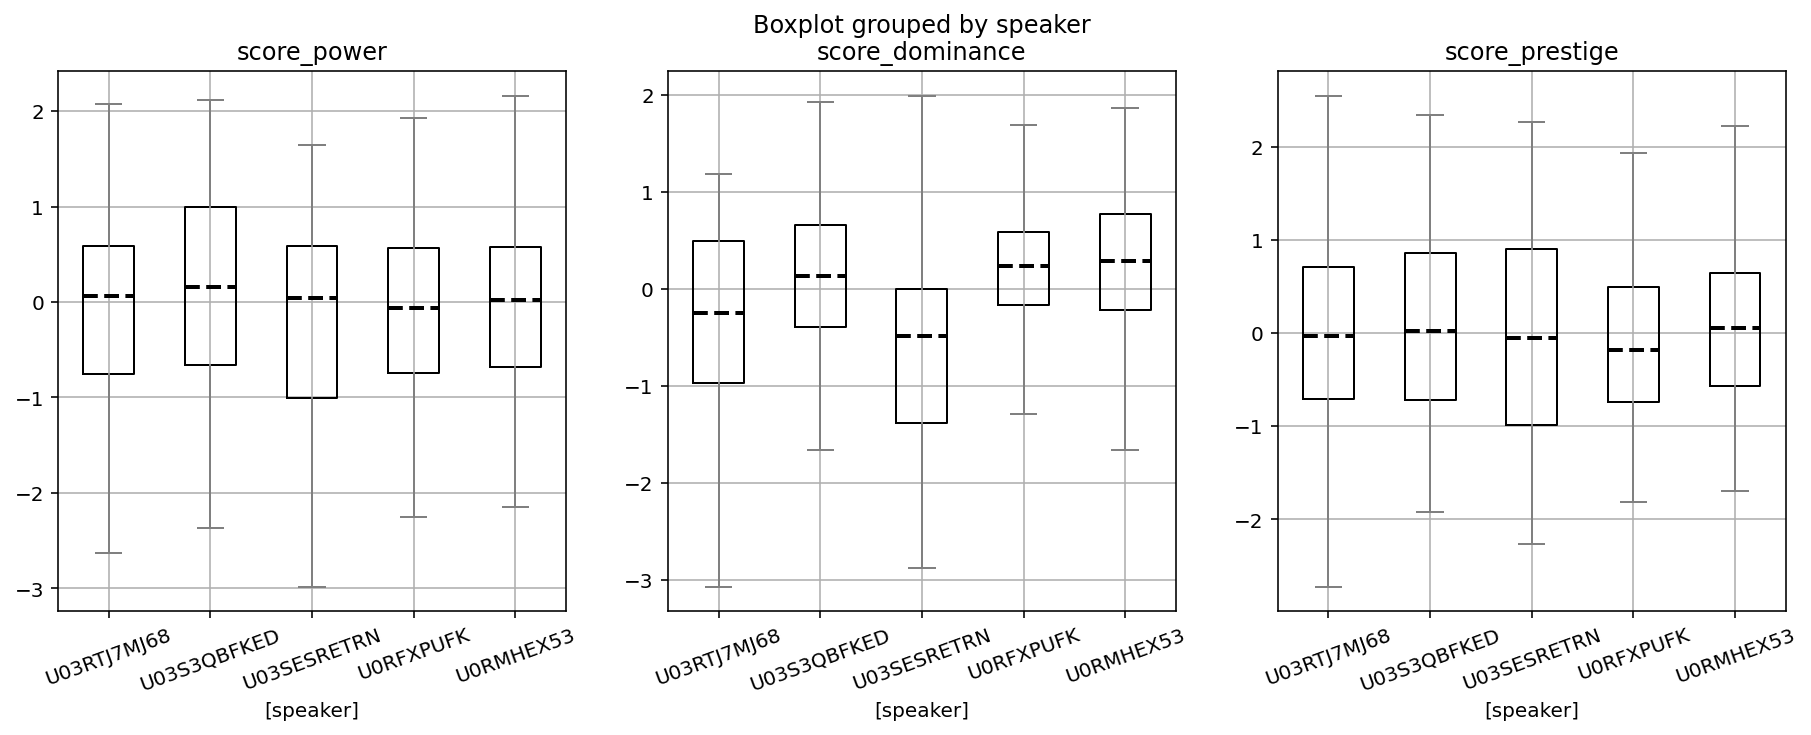

In [1023]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# for i, ax in enumerate(axes):
#     df_plt = pd.DataFrame(df_main[score_lst[i]])
#     df_plt.boxplot(ax=ax, by='speaker', showfliers=False, color='grey',
#                    boxprops=dict(linestyle='-', color='k', linewidth=1),
#                    medianprops=dict(linestyle='--', color='k', linewidth=2))
#     # Remove shared axis X
#     shax = ax.get_shared_x_axes()
#     shax.remove(ax)
#     plt.setp(ax.get_xticklabels(), rotation=20)
    
# plt.show()

### Pairwise T-test for all speaker-listener pairs

In [10]:
def ttest2(alice, bob, ks, alpha=0.05, df_main=df_main):
    # print('\n=== Pairwise ttest starts ===')
    # print('Sample a:', alice, 'Sample b:' ,bob)
    
    ga = df_main.loc[alice]
    gb = df_main.loc[bob]

    ma_lst = []
    va_lst = []
    mb_lst = []
    vb_lst = []
    t_lst = []
    p_lst = []
    
    na = len(ga)
    nb = len(gb)
    
    for k in ks:
        ma = ga[k].mean()
        va = ga[k].var()
        mb = gb[k].mean()
        vb = gb[k].var()
        equal_var = True
        if (na > nb and va/vb > 4) or (nb > na and vb/va > 4):
            equal_var = False
        rslt = stats.ttest_ind(a=ga[k], b=gb[k], equal_var=equal_var)
        t = rslt[0]
        p = rslt[1]
        if p < alpha: 
            p = str(p) + ' < ' + str(alpha)
        else:
            p = str(p)
        ma_lst.append(ma)
        va_lst.append(va)
        mb_lst.append(mb)
        vb_lst.append(vb)
        t_lst.append(t)
        p_lst.append(str(p))
    
    df_ttest2 = pd.DataFrame(
        list(zip(ma_lst, va_lst, mb_lst, vb_lst, t_lst, p_lst)), 
        columns=['mean_a','var_a', 'mean_b', 'var_b', 't_value', 'p_value'],
        index = ks)
    
    return df_ttest2

# Save
for speaker in speaker_lst:
    for other in speaker_lst:
        if other != speaker:
            df_ttest2 = ttest2(speaker, other, power_cat_lst, alpha=0.05, df_main=df_main)
            df_ttest2.to_csv('results/liwc_ttest_' + '_'.join((speaker,other)) + '.csv')

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_13297/2870704506.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  if (na > nb and va/vb > 4) or (nb > na and vb/va > 4):
/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_13297/2870704506.py:24: RuntimeWarning: invalid value encountered in double_scalars
  if (na > nb and va/vb > 4) or (nb > na and vb/va > 4):


In [47]:
################################################################################
##################################### END ######################################
################################################################################

In [11]:
################################################################################
##################################### END ######################################
################################################################################

In [12]:
################################################################################
##################################### END ######################################
################################################################################

In [56]:
# Example t-test results
# df_ttest2_active = ttest2(alice_active, bob_active, power_cat_lst, alpha=0.05, df_main=df_main)
# df_ttest2_active

/var/folders/8c/s7c_mn8d05q5mk1frz6_nld80000gn/T/ipykernel_1203/3200784026.py:32: RuntimeWarning: divide by zero encountered in double_scalars
  if na > nb and va/vb > 4:


,mean_a,var_a,mean_b,var_b,t_value,p_value
Clout,52.753,37.867,53.994,36.740,-0.301,0.763944
Tone,52.804,37.766,46.660,35.221,1.519,0.129688
WPS,13.262,8.140,11.343,8.452,2.094,0.037056 < 0.05
adverb,6.758,8.012,5.818,6.842,1.137,0.25652
negate,1.070,4.527,0.842,2.213,0.571,0.568284
adj,5.319,8.771,6.207,6.758,-1.020,0.308686
tone_neg,0.613,3.256,0.399,1.765,0.731,0.465378
emo_anx,0.053,0.693,0.071,0.890,-0.210,0.834095
emo_sad,0.150,1.444,0.000,0.000,1.360,0.175606
Cognition,13.614,12.772,15.266,10.288,-1.282,0.200858


### Compare the weekly patterns of selected pairs

In [985]:
# style_lst = ['d:', '*--', '.--', 'o-', 'x-', '+-', '.-', '^-', 'v-']

# def get_sig(x, num=5):
#     new_x = [(k,v) for k, v in sorted(x.items(), key=lambda item: item[1])]
#     return new_x[:num]

# def draw_weekly(dim, ym1, ym2, xt1, xt2):
#     # for i,dim in eumerate(['active']+dim_lst):
#     alice = alice_dct[dim]
#     bob = bob_dct[dim]
#     sig_cat_p_dct = dict(zip(df_sig.loc[dim].category, df_sig.loc[dim].p_value))
#     sig_tup_lst = get_sig(sig_cat_p_dct)
#     sig_cat_lst = [x[0] for x in sig_tup_lst]
#     # sig_cat_lst = sorted(df_sig.loc[dim].category)[:3]
#     df_weekly_dim = df_main.groupby(['speaker','week'])[sig_cat_lst].mean()
    
#     # week_lst = list(range(329,335))

#     fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#     # Alice weekly
#     df_weekly_dim.loc[alice].plot(ax=axes[0], style=style_lst[:len(sig_cat_lst)], color='k', linewidth=0.2)
#     axes[0].set_title(xt1)
#     axes[0].set_xlim(328.9, 334.1)
#     axes[0].set_ylim(-1, ym1)
#     # df_weekly_power.loc[alice][score_lst].plot(style=style_lst[:len(score_lst)], color='k', linewidth=0.5)

#     # Bob weekly
#     df_weekly_dim.loc[bob].plot(ax=axes[1], style=style_lst[:len(sig_cat_lst)], color='k', linewidth=0.2)
#     axes[1].set_title(xt2)
#     axes[1].set_xlim(328.9, 334.1)
#     axes[1].set_ylim(-1, ym2)
    
#     plt.show()

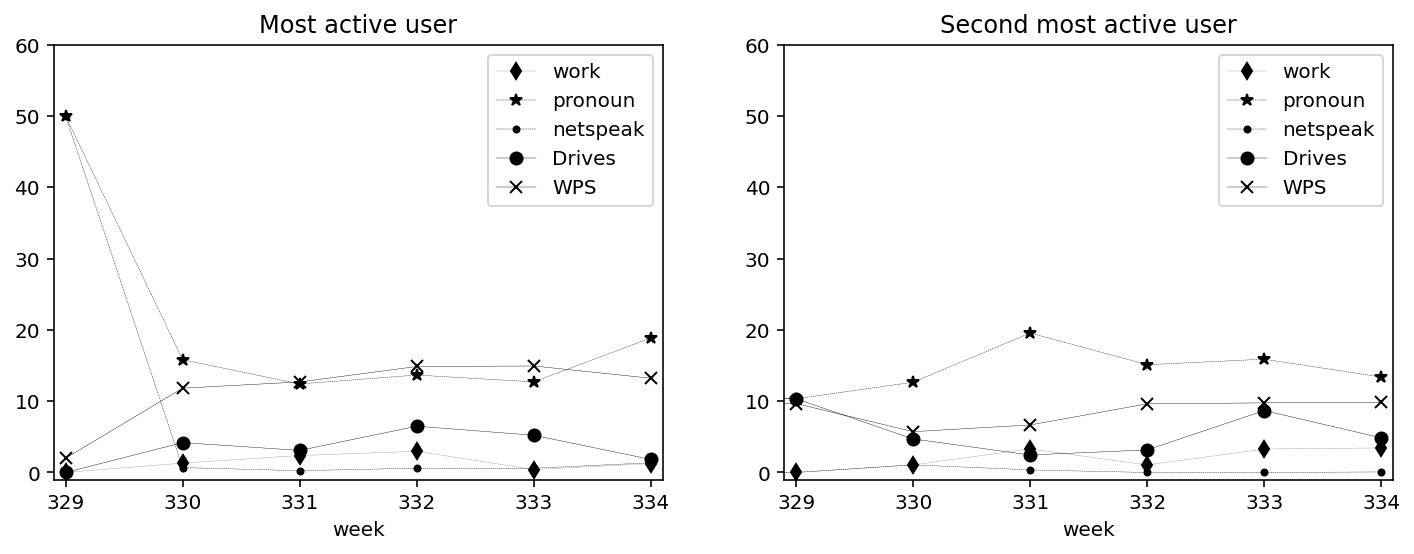

In [990]:
# draw_weekly('active', 60, 60, 'Most active user', 'Second most active user')

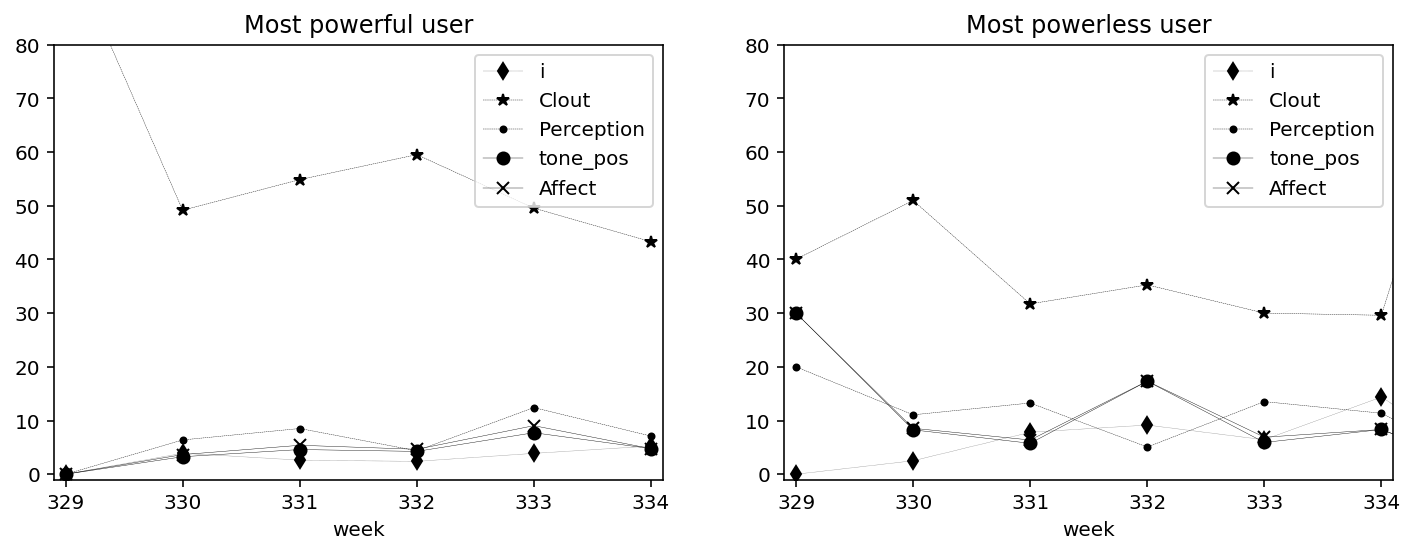

In [993]:
# draw_weekly('power', 80, 80, 'Most powerful user', 'Most powerless user')